## Exploratory Data Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

BASE = '..'
INPUT = os.path.join(BASE, 'data', 'Nova_pay_cleaned_dataset.csv')

df = pd.read_csv(INPUT, parse_dates=['timestamp'])

In [2]:
# Feature Enginering - Create columns for time of the day, day of week, hour_group, risk_score_bin

df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()


def map_hour_group(h):
    if 0 <= h < 4:
        return "Late Night"
    elif 4 <= h < 8:
       return "Early Morning"
    elif 8 <= h < 18:
       return "Work Hours"
    else:
       return "Evening"

df['hour_group'] = df['hour'].apply(map_hour_group)


# Create bins for the risk score
df["risk_bin"] = pd.cut(df["risk_score_internal"], bins=[0,0.2,0.4,0.6,0.8,1.0])

# save engineered columns
feat_out = os.path.join(BASE, 'data', 'Nova_pay_features.csv')
df.to_csv(feat_out, index=False)
print(df.shape)
print('Saved features to', feat_out)

(11192, 31)
Saved features to ..\data\Nova_pay_features.csv


### Visualization

Text(0.5, 1.0, 'Fraud Rate (%) by Transaction Velocity (24hr)')

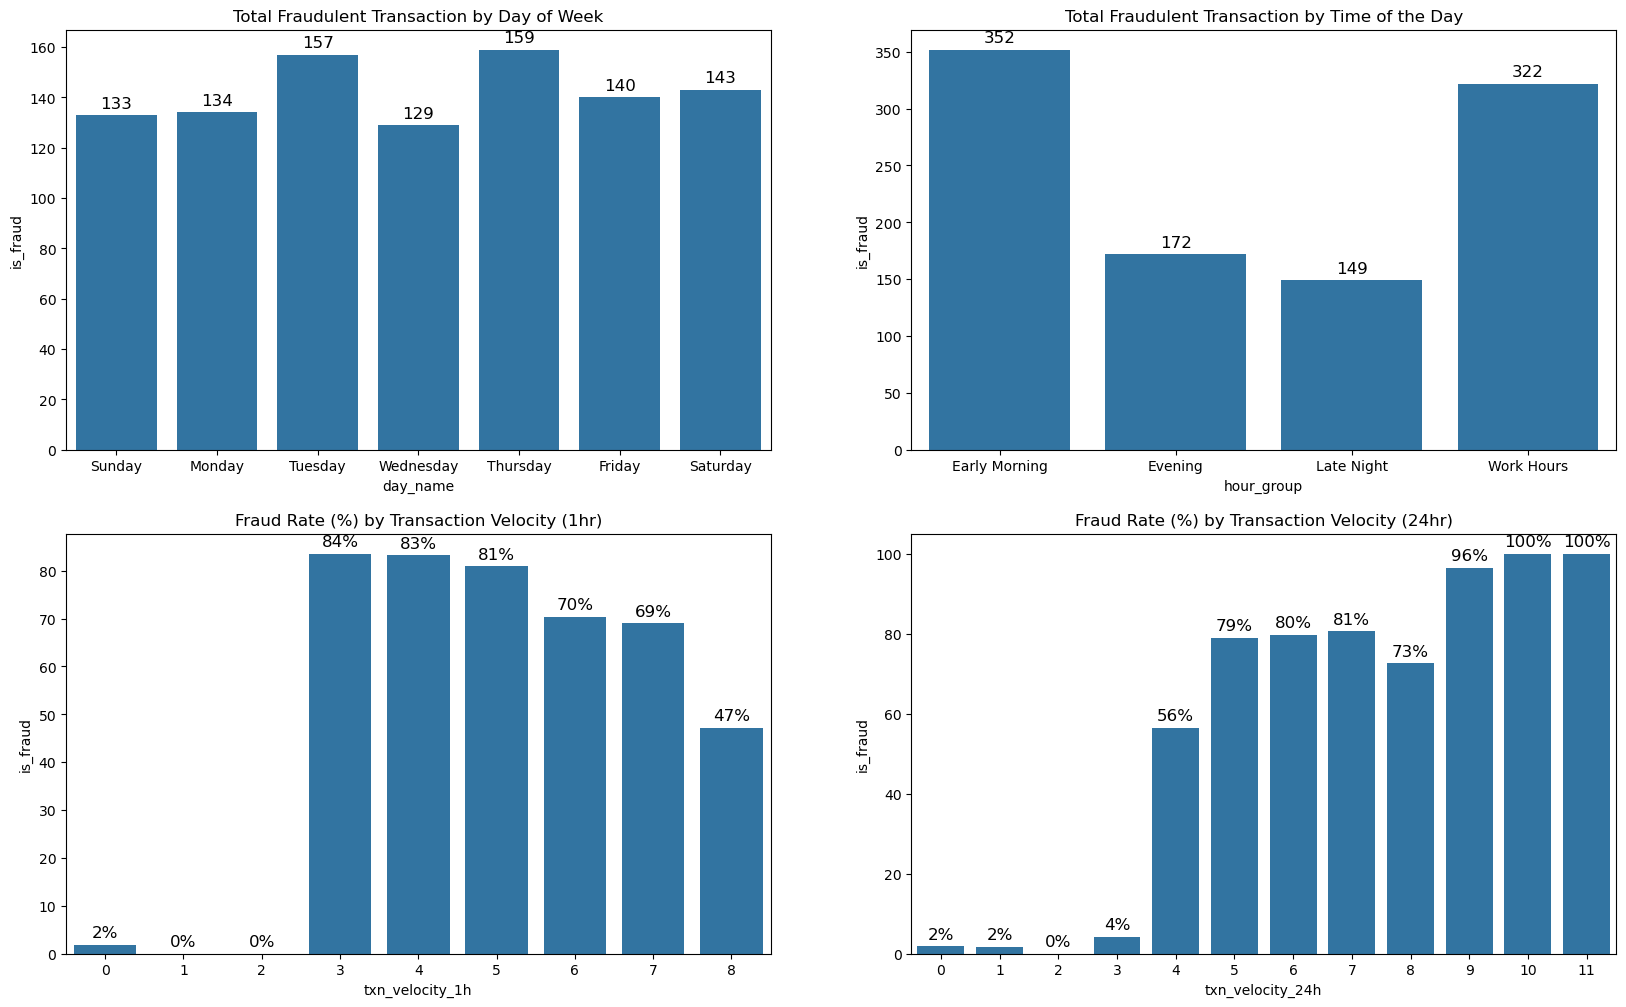

In [3]:
# is_fraud by time and transaction velocity

fig, axs =plt.subplots(nrows=2, ncols=2, figsize=(20,12))

fraud_by_day = df.groupby("day_name")["is_fraud"].sum().reset_index()
day_order = ["Sunday","Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
fraud_by_day["day_name"] = pd.Categorical(fraud_by_day["day_name"], categories=day_order, ordered=True)
fraud_by_day = fraud_by_day.sort_values("day_name")
sns.barplot(x="day_name", data=fraud_by_day, y="is_fraud", ax=axs[0,0])
for container in axs[0,0].containers:
    axs[0,0].bar_label(container, fmt='%.0f', padding=3, fontsize=12)
axs[0,0].set_title("Total Fraudulent Transaction by Day of Week")

fraud_by_hour = df.groupby("hour_group")["is_fraud"].sum().reset_index()
sns.barplot(x="hour_group", data=fraud_by_hour, y="is_fraud", ax=axs[0,1])
for container in axs[0,1].containers:
    axs[0,1].bar_label(container, fmt='%.0f', padding=3, fontsize=12)
axs[0,1].set_title("Total Fraudulent Transaction by Time of the Day")

fraud_rate = (df.groupby("txn_velocity_1h")["is_fraud"].mean()*100).reset_index()
sns.barplot(x="txn_velocity_1h", data=fraud_rate, y="is_fraud", ax=axs[1,0])
for container in axs[1,0].containers:
    axs[1,0].bar_label(container, fmt='%.0f%%', padding=3, fontsize=12)
axs[1,0].set_title("Fraud Rate (%) by Transaction Velocity (1hr)")

fraud_rate2 = (df.groupby("txn_velocity_24h")["is_fraud"].mean()*100).reset_index()
sns.barplot(x="txn_velocity_24h", data=fraud_rate2, y="is_fraud", ax=axs[1,1])
for container in axs[1,1].containers:
    axs[1,1].bar_label(container, fmt='%.0f%%', padding=3, fontsize=12)
axs[1,1].set_title("Fraud Rate (%) by Transaction Velocity (24hr)")

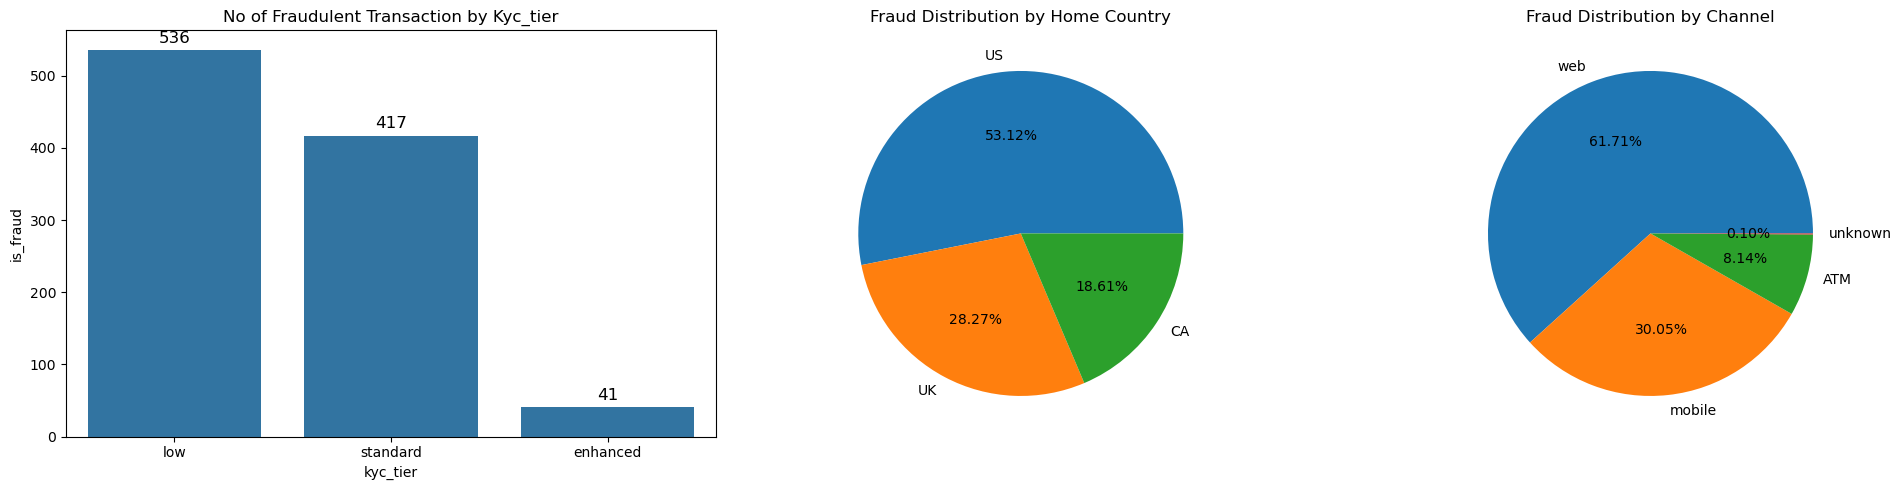

In [4]:
fig, axs =plt.subplots(nrows=1, ncols=3, figsize=(20,5))

fraud_by_kyc_tier = df.groupby("kyc_tier")["is_fraud"].sum().reset_index().sort_values("is_fraud", ascending=False)
sns.barplot(x="kyc_tier", data=fraud_by_kyc_tier, y="is_fraud", ax=axs[0])
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%.0f', padding=3, fontsize=12)
axs[0].set_title("No of Fraudulent Transaction by Kyc_tier")

fraud_by_country = df.groupby("home_country")["is_fraud"].sum().sort_values(ascending=False)
axs[1].pie(fraud_by_country.values, labels=fraud_by_country.index, autopct=lambda p:f'{p:.2f}%')
axs[1].set_title("Fraud Distribution by Home Country")

fraud_by_channel = df.groupby("channel")["is_fraud"].sum().sort_values(ascending=False)
axs[2].pie(fraud_by_channel.values, labels=fraud_by_channel.index, autopct=lambda p:f'{p:.2f}%')
axs[2].set_title("Fraud Distribution by Channel")

plt.tight_layout()
plt.show();


Text(0.5, 1.0, 'Fraud Rate (%) by Risk Score')

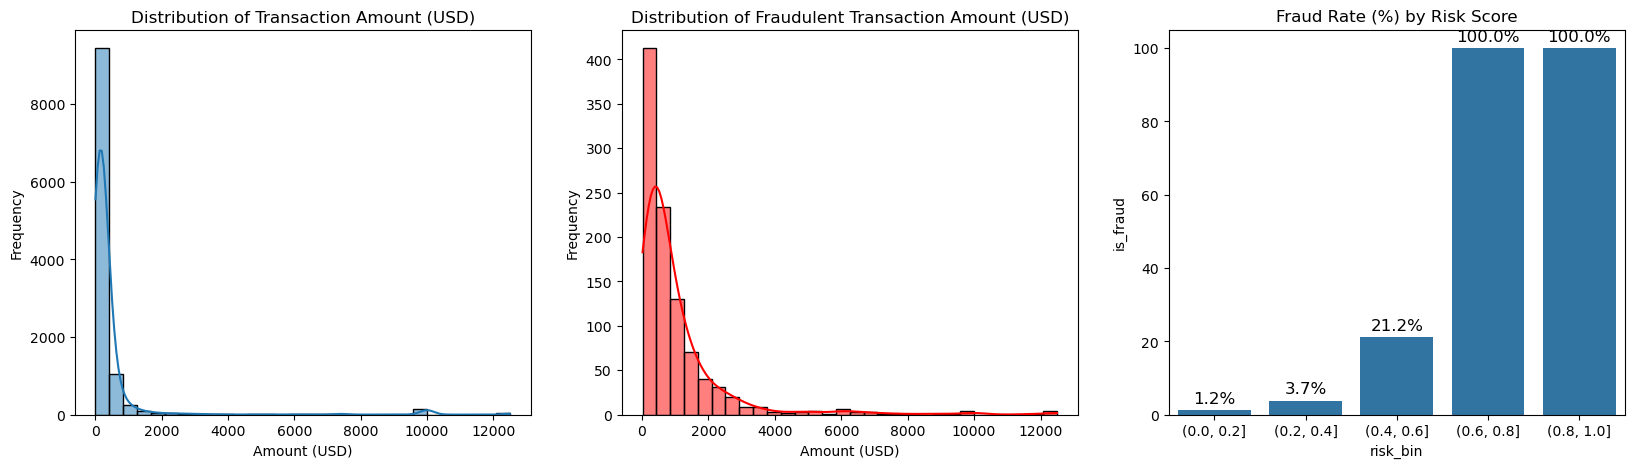

In [5]:
fig, axs =plt.subplots(nrows=1, ncols=3, figsize=(20,5))

sns.histplot(df["amount_usd"], bins=30, kde=True, ax=axs[0])
axs[0].set_title("Distribution of Transaction Amount (USD)")
axs[0].set_xlabel("Amount (USD)")
axs[0].set_ylabel("Frequency")

sns.histplot(df[df["is_fraud"] == 1]["amount_usd"], bins=30, kde=True, color='red', ax=axs[1])
axs[1].set_title("Distribution of Fraudulent Transaction Amount (USD)")
axs[1].set_xlabel("Amount (USD)")
axs[1].set_ylabel("Frequency")

risk_bin_rate = (df.groupby("risk_bin", observed=False)["is_fraud"].mean() * 100).reset_index()
sns.barplot(data=risk_bin_rate, x="risk_bin", y="is_fraud", ax=axs[2])
for container in axs[2].containers:
    axs[2].bar_label(container, fmt='%.1f%%', padding=3, fontsize=12)
axs[2].set_title("Fraud Rate (%) by Risk Score")

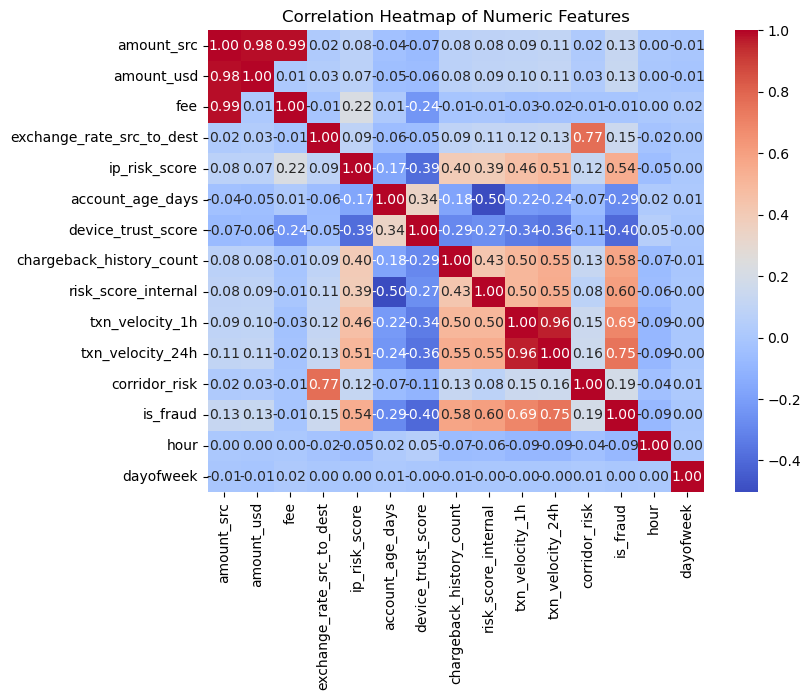

In [6]:
numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

#### Class Imbalance check

is_fraud
0    91.109721
1     8.890279
Name: proportion, dtype: float64


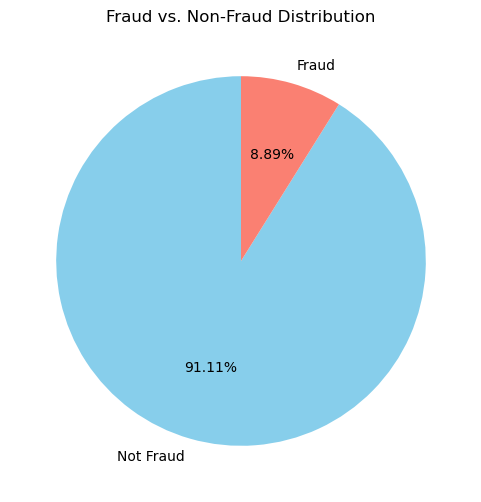

In [7]:
# Class distribution
fraud_counts = df['is_fraud'].value_counts(normalize=True) * 100
print(fraud_counts)

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=['Not Fraud', 'Fraud'], autopct='%1.2f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Fraud vs. Non-Fraud Distribution')
plt.show()


#### Log Scaled Amount Distribution

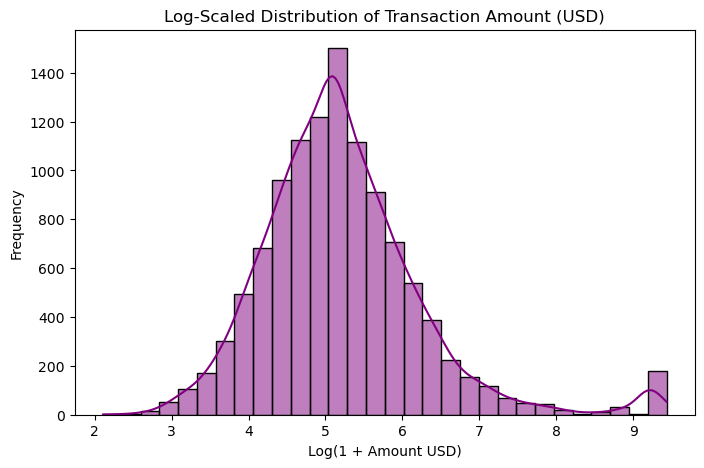

In [8]:
# Log-transform
df['log_amount_usd'] = np.log1p(df['amount_usd'])

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(df['log_amount_usd'], bins=30, kde=True, color='purple')
plt.title('Log-Scaled Distribution of Transaction Amount (USD)')
plt.xlabel('Log(1 + Amount USD)')
plt.ylabel('Frequency')
plt.show()


#### Fraud Rate by KYC Tier (%)

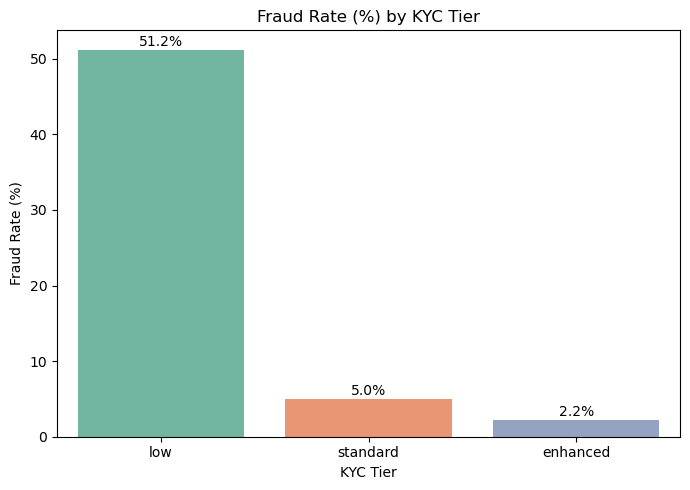

In [13]:
# Prepare fraud rate data
fraud_rate_kyc = df.groupby('kyc_tier')['is_fraud'].mean().sort_values(ascending=False) * 100

# Bar plot without deprecated behavior
plt.figure(figsize=(7, 5))
sns.barplot(x=fraud_rate_kyc.index, y=fraud_rate_kyc.values, hue=fraud_rate_kyc.index, palette='Set2', dodge=False, legend=False)
plt.title('Fraud Rate (%) by KYC Tier')
plt.ylabel('Fraud Rate (%)')
plt.xlabel('KYC Tier')

# Add percentage labels
for i, val in enumerate(fraud_rate_kyc.values):
    plt.text(i, val + 0.5, f'{val:.1f}%', ha='center')
plt.tight_layout()
plt.show()


#### Top Home Countries by Fraud Rate

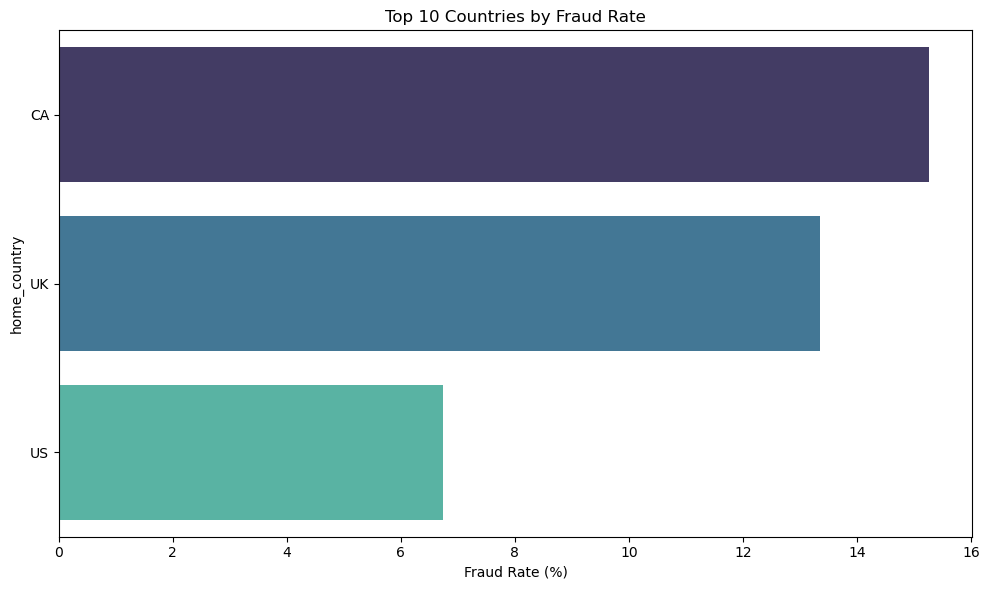

In [15]:
# Top 10 countries with highest fraud rates
fraud_rate_country = df.groupby('home_country')['is_fraud'].mean() * 100
top10_fraud_countries = fraud_rate_country.sort_values(ascending=False).head(5)

# Convert to DataFrame for seaborn
top10_df = top10_fraud_countries.reset_index().rename(columns={'is_fraud': 'fraud_rate'})

# Bar plot with hue matching y-axis
plt.figure(figsize=(10, 6))
sns.barplot(data=top10_df, x='fraud_rate', y='home_country', hue='home_country', dodge=False, palette='mako', legend=False)
plt.xlabel('Fraud Rate (%)')
plt.title('Top 10 Countries by Fraud Rate')
plt.tight_layout()
plt.show()


#### Device Trust Score by Fraud Status

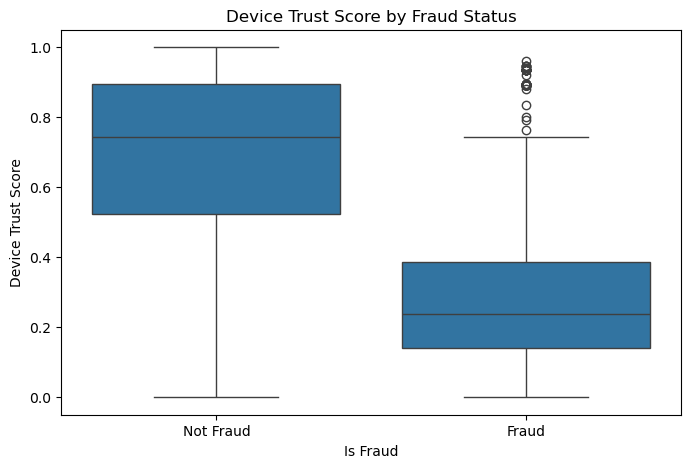

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_fraud', y='device_trust_score', data=df)
plt.title('Device Trust Score by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Device Trust Score')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()


#### Correlation Filtering (with Target)

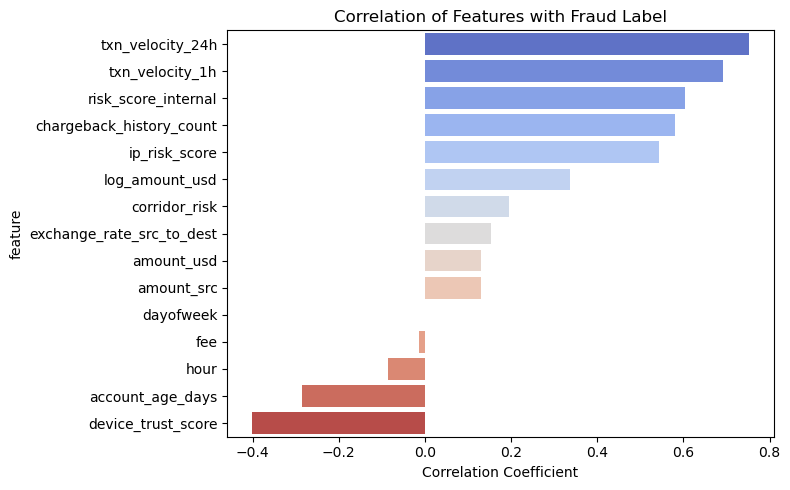

In [16]:
# Compute correlations
numeric_df = df.select_dtypes(include=np.number)
corr_with_target = numeric_df.corr()['is_fraud'].drop('is_fraud').sort_values(ascending=False)

# Convert to DataFrame for Seaborn
corr_df = corr_with_target.reset_index().rename(columns={'index': 'feature', 'is_fraud': 'correlation'})

# Plot using 'hue' to avoid warning
plt.figure(figsize=(8, 5))
sns.barplot(data=corr_df, x='correlation', y='feature', hue='feature', palette='coolwarm', dodge=False, legend=False)
plt.title('Correlation of Features with Fraud Label')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()
